In [35]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import functools
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split

# --- My stuff
from helpers import kl_loss, make_train_generator
from ptsne_parameters import (csv_file, num_outputs, num_clusters, alpha,
        perplexity, model_name, batch_size, epochs, save_results, show_plot)

In [36]:
TARGET_DICT = {0: "dyed_lifted_polyps",
               1: "dyed_resection_margins",
               2: "esophagitis",
               3: "normal_cecum",
               4: "normal_pylorus",
               5: "normal_z_line",
               6: "polyps",
               7: "ulcerative_colitis"}

def get_data(csv_file, n_samples=None):
   
    inv_target_dict = {v: k for k, v in TARGET_DICT.items()}

    latent_features_dataset = csv_file
    df = pd.read_csv(latent_features_dataset, index_col=0)

    if n_samples is not None:
        df = df.sample(n=n_samples)

    features = df.keys()[0:-1]
    targets = df.target.values
    data = np.array(df[features])
    labels = np.array([inv_target_dict[_i] for _i in targets])

    return data, labels

def make_model(num_outputs):
    #all_layer_sizes = [num_inputs, 500, 500, 2000, num_outputs]
    #all_layers = make_layers(all_layer_sizes)
    inputs = tf.keras.Input(shape=(num_inputs,))
    next_layer = tf.keras.layers.Dense(500,
            activation=tf.nn.sigmoid)(inputs)
    next_layer = tf.keras.layers.Dense(500,activation=tf.nn.sigmoid,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            )(next_layer)
    next_layer = tf.keras.layers.Dense(2000,activation=tf.nn.sigmoid,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            )(next_layer)
    outputs=tf.keras.layers.Dense(num_outputs,activation=tf.keras.activations.linear,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            )(next_layer)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    kl_loss_func = functools.partial(kl_loss, alpha=alpha,
        batch_size=batch_size)
    kl_loss_func.__name__ = 'KL-Divergence'

    optimiser = "adam"
    model.compile(optimizer=optimiser, loss=kl_loss_func, run_eagerly=True)
    print(model.summary())

    return model

def train_model(model, generator, num_samples, batch_size):
    steps_per_epoch = int(num_samples//batch_size)
    reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5,
            min_lr=0.001)
    early_stopping = EarlyStopping( monitor="loss", min_delta=0, patience=10,
            verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks = [reduce_lr, early_stopping]

    # TODO: Hyperparameter tuning - or RBM
    model.fit(generator,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            callbacks=callbacks)
    return model


In [37]:
# --- Data
data, labels = get_data(csv_file)
train_data, test_data, train_labels, test_labels = train_test_split(data,
        labels, test_size=0.05)
num_samples, num_inputs = train_data.shape
print("Samples: ", num_samples)
print("Dimensionality: ", num_inputs)

Samples:  1520
Dimensionality:  1024


In [38]:
# --- Make generator and model, and train
generator = make_train_generator(train_data, perplexity, batch_size)
model = make_model(num_outputs)
model = train_model(model, generator, num_samples, batch_size)
train_embedding = model.predict(train_data)
test_embedding = model.predict(test_data)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1024)]            0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               512500    
_________________________________________________________________
dense_5 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              1002000   
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 4002      
Total params: 1,769,002
Trainable params: 1,769,002
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
11/11 [==============================] - 1s 88ms/step - loss: 195.5576
Epoch 2/10
11/11 [=====

In [ ]:
# --- Save embeddings and model
np.save("embeddings.npy", train_embedding)
np.save("train_labels.npy", train_labels)
np.save("preds.npy", test_embedding)
np.save("test_labels.npy", test_labels)
model.save(model_name)

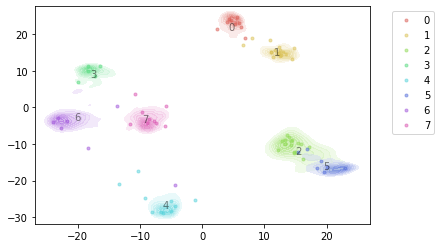

In [39]:
# --- Plot result with unseen samples
from make_plot import plot_kde, plot_clusters, plot_scatter
plot_kde(train_embedding, train_labels)
plot_scatter(test_embedding, test_labels)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

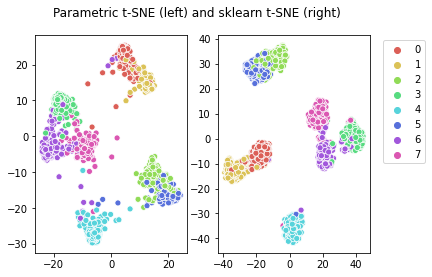

In [40]:
# --- Plot embedding compared to non-parametric t-SNE
from sklearn.manifold import TSNE
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Parametric t-SNE (left) and sklearn t-SNE (right)")
plot_clusters(train_embedding, train_labels, ax=ax1)
ax1.legend_.remove()
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=0)
tsne_embedding = tsne.fit_transform(train_data)
plot_clusters(tsne_embedding, train_labels, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Analyse embedded and new data

In [41]:
def euclidean_distance(source, target):
    return np.sqrt(sum(np.abs(source - target)))

def n_smallest(arr, n): 
    """ Returns indices of the n smalles elements of the numpy array 'arr'"""
    return arr.argsort()[:n]

In [ ]:
# --- Load embeddings from before
train_embedding = np.load("embeddings.npy")
train_labels = np.load("train_labels.npy")
test_embedding = np.load("preds.npy")
test_labels = np.load("test_labels.npy")

In [94]:
from ptsne_parameters import pred_index, n_neighbors

true_cluster = test_labels[pred_index]
print(f"True cluster: {true_cluster}, {TARGET_DICT.get(true_cluster, true_cluster)}")

# --- Prediction to explain
exp_pred = test_embedding[pred_index]
distances = np.array([euclidean_distance(_emb, exp_pred) for _emb in
    train_embedding])
n_indices = n_smallest(distances, n_neighbors)
n_embedded = train_embedding[n_indices]
n_labels = train_labels[n_indices]

True cluster: 2, esophagitis


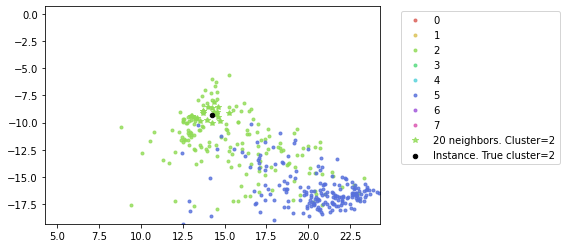

In [95]:
# --- Make universal color palette and plot all training embeddings
num_clusters = len(set(train_labels))
color_palette = sns.color_palette("hls", num_clusters)
plot_scatter(train_embedding, train_labels, color_palette=color_palette, alpha=0.8)

# --- Loop over neighboring classes and highlight neighbors
for _l in set(n_labels):
    _rows = (n_labels==_l)
    _n_l = list(n_labels).count(_l)
    plot_scatter(n_embedded[_rows], n_labels[_rows],
            color_palette=color_palette, alpha=0.8, marker='*',
            label=f"{_n_l} neighbors. Cluster={_l}")

# --- Highlight instance to explain on the plot
# --- True color: color_palette[test_labels[pred_index]]
plt.scatter(exp_pred[0], exp_pred[1], c="black", marker='o', 
            s=20, label=f"Instance. True cluster={true_cluster}", zorder=3)

# --- Zoom in on plot
x_range = [exp_pred[0]-10, exp_pred[0]+10]
y_range = [exp_pred[1]-10, exp_pred[1]+10]
plt.xlim(x_range)
plt.ylim(y_range)

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()